In [138]:
import pandas as pd
import numpy as np
import json
from scipy.stats import wasserstein_distance

import ast
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import Normalize

import numpy as np
import re
import math

In [139]:
def get_country_code_dict():
    country_path = "../dataset/country.jsonl"
    json_file = open(country_path)
    country_dict = json.load(json_file)
    return country_dict

def get_country_code_list():
    country_path = "../dataset/country.jsonl"
    json_file = open(country_path)
    country_dict = json.load(json_file)
    return list(country_dict.keys())

In [140]:
country_dict = get_country_code_dict()

In [141]:
country_dict

{'8': 'Albania',
 '12': 'Algeria',
 '16': 'American Samoa',
 '20': 'Andorra',
 '24': 'Angola',
 '28': 'Antigua and Barbuda',
 '32': 'Argentina',
 '51': 'Armenia',
 '36': 'Australia',
 '40': 'Austria',
 '31': 'Azerbaijan',
 '50': 'Bangladesh',
 '52': 'Barbados',
 '56': 'Belgium',
 '60': 'Bermuda',
 '64': 'Bhutan',
 '68': 'Bolivia',
 '70': 'Bosnia',
 '72': 'Botswana',
 '76': 'Brazil',
 '84': 'Belize',
 '100': 'Bulgaria',
 '854': 'Burkina Faso',
 '108': 'Burundi',
 '112': 'Belarus',
 '116': 'Cambodia',
 '120': 'Cameroon',
 '124': 'Canada',
 '148': 'Chad',
 '152': 'Chile',
 '156': 'China',
 '170': 'Colombia',
 '384': 'Côte d´Ivoire',
 '184': 'Cook Islands',
 '188': 'Costa Rica',
 '191': 'Croatia',
 '192': 'Cuba',
 '196': 'Cyprus',
 '203': 'Czech Republic',
 '180': 'Dem. Rep. of Congo',
 '208': 'Denmark',
 '214': 'Dominican Republic',
 '818': 'Egypt',
 '218': 'Ecuador',
 '222': 'El Salvador',
 '226': 'Equatorial Guinea',
 '231': 'Ethiopia',
 '232': 'Eritrea',
 '233': 'Estonia',
 '246': 'Fin

In [142]:
def get_question_dict():
    question_dict= dict()
    lm_data_path = "../results/RQ1/gpt-4/results.csv"
    lm_df = pd.read_csv(lm_data_path)
    lm_df = lm_df[lm_df['type'] == 'Opinion-Dependent']
    for _, row in lm_df.iterrows():
        question_dict[row['id']] = ast.literal_eval(row['choice_keys'])
    return question_dict

In [143]:
question_dict = get_question_dict()

In [144]:
llm_name_dict = {
    "CohereLabs/aya-23-35B": "aya23",
    "meta-llama/Meta-Llama-3-70B-Instruct": "llama3",
    "Qwen/Qwen2.5-72B-Instruct": "qwen25",
    "gpt-3.5-turbo": "gpt35", 
    "gpt-4": "gpt4", 
    "deepseek-chat": "dsv3",
    "deepseek-reasoner": "dsr1"
}

In [145]:
def get_llm_distribution_by_country_and_question(question_item, llm_df):
    try:
        llm_distribution_rough = llm_df[llm_df['id'] == question_item[0]]['response'].values[0]
    except:
        return None
    try:
        prob_dict = ast.literal_eval(llm_distribution_rough)
    except:
        llm_distribution_rough = re.sub(r'(\d+):\s*([\d.]+%)', r"'\1': '\2'", llm_distribution_rough)
        prob_dict = ast.literal_eval(llm_distribution_rough)

    llm_distribution = {k: float(v.strip('%')) / 100 for k, v in prob_dict.items()}
    return llm_distribution

In [146]:
# llm = "gpt-3.5-turbo"
# llm = "gpt-4"
# llm = "CohereLabs/aya-23-35B"
# llm = "meta-llama/Meta-Llama-3-70B-Instruct"
# llm = "Qwen/Qwen2.5-72B-Instruct"
# llm = "deepseek-chat"
llm = "deepseek-reasoner"

In [147]:
llm_data_path = f"../results/RQ1/{llm}/results.csv"
llm_df = pd.read_csv(llm_data_path)
llm_df = llm_df[llm_df['type'] == 'Opinion-Dependent']

llm_od_dict = dict()
for (question_item) in question_dict.items():
    llm_distribution = get_llm_distribution_by_country_and_question(question_item, llm_df)
    if llm_distribution is None:
        continue
    llm_od_dict[question_item[0]] = llm_distribution

In [148]:
def get_human_distribution_by_question(question_item, human_df):
    human_df = human_df[question_item[0]]
    if human_df.empty:
        return None
    
    human_df = human_df.value_counts().sort_index()

    human_distribution = {}
    is_ok = False
    for c in question_item[1]:
        if int(c) not in human_df.index:
            human_distribution[c] = 0
        else:
            human_distribution[c] = human_df[int(c)]
            is_ok = True
    if not is_ok:
        return None
    human_distribution = {k: float(v / sum(human_distribution.values())) for k, v in human_distribution.items()}
    return human_distribution

In [149]:
human_data_path = "../dataset/wvs/WV7.csv"
human_df = pd.read_csv(human_data_path, low_memory=False)

human_od_dict = dict()
for (question_item) in question_dict.items():
    human_distribution = get_human_distribution_by_question(question_item, human_df)
    if human_distribution is None:
        continue
    human_od_dict[question_item[0]] = human_distribution

In [150]:
def get_human_distribution_by_country_and_question(country_code, question_item, human_df):
    human_df = human_df[human_df['B_COUNTRY'] == int(country_code)][question_item[0]]
    if human_df.empty:
        return None
    
    human_df = human_df.value_counts().sort_index()

    human_distribution = {}
    is_ok = False
    for c in question_item[1]:
        if int(c) not in human_df.index:
            human_distribution[c] = 0
        else:
            human_distribution[c] = human_df[int(c)]
            is_ok = True
    if not is_ok:
        return None
    human_distribution = {k: float(v / sum(human_distribution.values())) for k, v in human_distribution.items()}
    return human_distribution

In [151]:
def alignment_score(D1, D2, Q):
    scores = []
    for q in Q:
        if q not in D1 or q not in D2:
            continue
        
        p1 = D1[q]
        p2 = D2[q]

        if len(p1) != len(p2):
            continue
        N = len(p1) 
        support = np.array([int(k) for k, v in sorted(p1.items())])
        wd = wasserstein_distance(support, support, [v for k, v in sorted(p1.items())], [v for k, v in sorted(p2.items())])
        score = 1 - wd / (N - 1)
        scores.append(score)
    return np.round(np.mean(scores), 4), np.round(np.std(scores), 4)

In [152]:
def shannon_entropy(p_list, base=2):
    probs = [float(p) for p in p_list if p > 0]
    s = sum(probs)
    if not math.isclose(s, 1.0, rel_tol=1e-9, abs_tol=1e-12):
        probs = [p / s for p in probs]
    log_fn = {2: math.log2, math.e: math.log, 10: math.log10}.get(base, lambda x: math.log(x, base))
    return -sum(p * log_fn(p) for p in probs)

In [153]:
def inconsistency_score(D):
    score_list = []
    for k, v in D.items():
        score =  shannon_entropy([p for p in v.values()], base=2) / math.log(len(v), 2)
    score_list.append(score)
    return np.round(np.mean(score_list), 4)

In [154]:
country_code_list = get_country_code_list()
country_score_dict = dict()
country_std_dict = dict()
country_inconsistency_score_dict = dict()
for country_code in country_code_list:
    country_od_dict = dict()
    for (question_item) in question_dict.items():
        human_distribution = get_human_distribution_by_country_and_question(country_code, question_item, human_df)
        if human_distribution is None:
            continue
        country_od_dict[question_item[0]] = human_distribution

    if len(country_od_dict) == 0:
        continue

    llm_score, llm_std = alignment_score(llm_od_dict, country_od_dict, question_dict.keys())
    
    country_inconsistency_score = inconsistency_score(country_od_dict)
    country_score_dict[country_dict.get(country_code)] = llm_score
    country_std_dict[country_dict.get(country_code)] = llm_std
    country_inconsistency_score_dict[country_dict.get(country_code)] = country_inconsistency_score

In [155]:
sorted_data = sorted(country_score_dict.items(), key=lambda x: x[1], reverse=True)
countries = []
means = []
cis = []
for country, score in sorted_data:
    countries.append(country)
    means.append(score)
    cis.append(country_std_dict[country])

/tmp/ipykernel_4177268/2771968169.py:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('viridis')


[np.float64(0.8972), np.float64(0.8948), np.float64(0.8933), np.float64(0.8921), np.float64(0.8921), np.float64(0.8908), np.float64(0.8895), np.float64(0.8885), np.float64(0.885), np.float64(0.8841), np.float64(0.884), np.float64(0.8813), np.float64(0.8789), np.float64(0.8784), np.float64(0.8757), np.float64(0.8756), np.float64(0.8749), np.float64(0.8745), np.float64(0.8732), np.float64(0.8725), np.float64(0.8668), np.float64(0.8666), np.float64(0.8664), np.float64(0.8664), np.float64(0.866), np.float64(0.8656), np.float64(0.8656), np.float64(0.8655), np.float64(0.8627), np.float64(0.8626), np.float64(0.8623), np.float64(0.862), np.float64(0.8619), np.float64(0.8596), np.float64(0.857), np.float64(0.8561), np.float64(0.8553), np.float64(0.8546), np.float64(0.8529), np.float64(0.8519), np.float64(0.8517), np.float64(0.8504), np.float64(0.85), np.float64(0.8486), np.float64(0.8478), np.float64(0.8397), np.float64(0.8394), np.float64(0.8356), np.float64(0.8325), np.float64(0.8287), np.flo

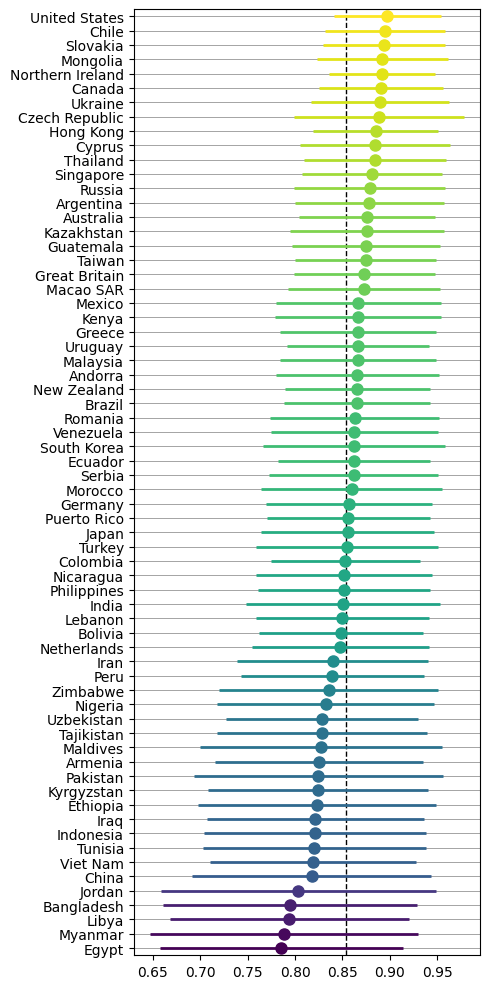

In [156]:
lower = np.array(means) - np.array(cis)
upper = np.array(means) + np.array(cis)
y_pos = np.arange(len(countries))

cmap = cm.get_cmap('viridis')         
norm = Normalize(vmin=min(means), vmax=max(means))
colors = cmap(norm(means))

fig, ax = plt.subplots(figsize=(5, 10))
for i, (low, up) in enumerate(zip(lower, upper)):
    ax.hlines(y_pos[i], low, up, colors=colors[i], linewidth=2, zorder=3)
print(means)
for i, m in enumerate(means):
    ax.plot(m, y_pos[i], 'o', markersize=8, color=colors[i], markeredgecolor=colors[i], zorder=2)

ax.set_yticks(y_pos)
ax.set_yticklabels(countries)
ax.set_ylim(len(countries) - 0.5, -0.5)
ax.margins(y=0)

mean_value = np.mean(means)
ax.axvline(mean_value, linestyle='--', linewidth=1, color='black', zorder=1)

ax.yaxis.grid(True,color='grey', linewidth=0.5)
plt.tight_layout()
plt.savefig(f"../figures/SM/compare_countries_{llm_name_dict[llm]}.pdf", dpi=300)
